In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

In [2]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
dataset = pd.read_csv(r'Documents/TWITTERDS.csv', encoding = 'latin1')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10076 entries, 0 to 10075
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TAR          10076 non-null  int64 
 1   ID           10076 non-null  int64 
 2   DATE         10076 non-null  object
 3   QUERY        10076 non-null  object
 4   NAME         10076 non-null  object
 5   DESCRIPTION  10076 non-null  object
dtypes: int64(2), object(4)
memory usage: 472.4+ KB


In [3]:
len(dataset)

10076

In [4]:
reviews = dataset['DESCRIPTION'].values
sentiments = dataset['TAR'].values

train_reviews = reviews[:10076]
train_sentiments = sentiments[:10076]

test_reviews = reviews[:8000]
test_sentiments = sentiments[:8000]
reviews
len(train_reviews)
train_sentiments

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [5]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [6]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  0%|          | 0/10076 [00:00<?, ?it/s]C:\Users\user\anaconda3\envs\env1\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 8000/8000 [00:01<00:00, 5478.53it/s]

Wall time: 3.24 s


In [7]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [8]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('saviour', 18929), ('<PAD>', 0), 1)

In [9]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [10]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [11]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=18930
Number of Documents=10076


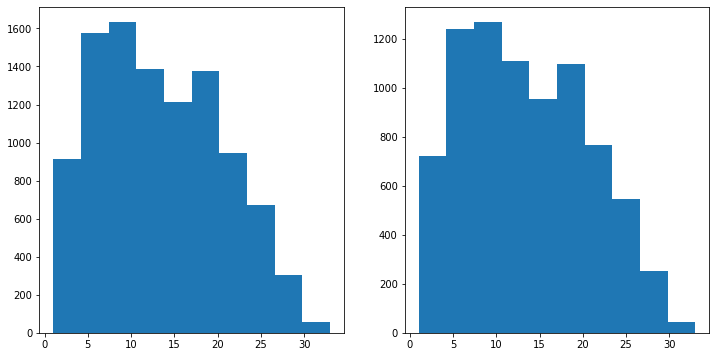

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [13]:
MAX_SEQUENCE_LENGTH = 100

In [14]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((10076, 100), (8000, 100))

In [15]:
le = LabelEncoder()
num_classes=2

In [16]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [17]:
VOCAB_SIZE = len(t.word_index)

In [18]:
EMBED_SIZE = 300
EPOCHS=5
BATCH_SIZE=1500

In [19]:
# create the model

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          5679000   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 32)            8

In [20]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5503WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001FF0AB86558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

In [21]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

250/250 [==============================] - 3s 12ms/step - loss: 0.1645 - accuracy: 0.9366
Accuracy: 93.66%


In [22]:
predictions = model.predict(X_test).ravel()
classes_x=np.argmax(predictions,axis=0)
type(classes_x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - 3s 11ms/step


numpy.int64

In [23]:
predictions = np.round(predictions).astype(int)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ['negative','positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4999
           1       0.87      0.97      0.92      3001

    accuracy                           0.94      8000
   macro avg       0.93      0.94      0.93      8000
weighted avg       0.94      0.94      0.94      8000



,negative,positive
negative,4576,423
positive,84,2917
